base de datos: https://www.kaggle.com/datasets/muhammaddawood42/nvidia-stock-data

In [ ]:
import pandas as pd

df = pd.read_csv("NVIDIA_STOCK.csv")

#primeras filas y las columnas
df.head(), df.columns


(        Price           Adj Close               Close               High  \
 0      Ticker                NVDA                NVDA               NVDA   
 1        Date                 NaN                 NaN                NaN   
 2  2018-01-02   4.929879665374756   4.983749866485596  4.987500190734863   
 3  2018-01-03   5.254334926605225  5.3117499351501465   5.34250020980835   
 4  2018-01-04  5.2820329666137695   5.339749813079834  5.451250076293945   
 
                  Low               Open     Volume  
 0               NVDA               NVDA       NVDA  
 1                NaN                NaN        NaN  
 2  4.862500190734863  4.894499778747559  355616000  
 3            5.09375  5.102499961853027  914704000  
 4  5.317249774932861  5.394000053405762  583268000  ,
 Index(['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object'))

In [ ]:
#filas eliminadas
df_clean = df.iloc[2:].copy()

df_clean.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Close'] = pd.to_numeric(df_clean['Close'], errors='coerce')

#valores nulos
df_clean.dropna(subset=['Close'], inplace=True)

#índice
df_clean.reset_index(drop=True, inplace=True)
df_clean.head()


,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929879665374756,4.98375,4.987500190734863,4.862500190734863,4.894499778747559,355616000
1,2018-01-03,5.254334926605225,5.31175,5.34250020980835,5.09375,5.102499961853027,914704000
2,2018-01-04,5.2820329666137695,5.33975,5.451250076293945,5.317249774932861,5.394000053405762,583268000
3,2018-01-05,5.326793670654297,5.38500,5.422749996185303,5.2769999504089355,5.354750156402588,580124000
4,2018-01-08,5.490012168884277,5.55000,5.625,5.4644999504089355,5.510000228881836,881216000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("NVIDIA_STOCK.csv")

#no datos
df = df.iloc[2:].copy()
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

#tipos de datos
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(subset=['Close'], inplace=True)

#Precios
close_prices = df[['Close']].values

scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)


In [ ]:
n = len(close_scaled)
train_size = int(n * 0.8)
train = close_scaled[:train_size]
test = close_scaled[train_size:]


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


close_prices = df_clean[['Close']].values

#datos entre 0 y 1
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)

#entrada: días pasados y salida: días futuros
input_length = 30
forecast_length = 7

X, y = [], []
for i in range(len(close_scaled) - input_length - forecast_length):
    X.append(close_scaled[i:i + input_length])
    y.append(close_scaled[i + input_length:i + input_length + forecast_length])

X = np.array(X)
y = np.array(y)

#wntrenamiento
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1328, 30, 1), (1328, 7, 1), (332, 30, 1), (332, 7, 1))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

input_length = 30
forecast_length = 7

encoder_inputs = Input(shape=(input_length, 1))
encoder_lstm = LSTM(100, activation='relu', return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = RepeatVector(forecast_length)(encoder_outputs)
decoder_lstm = LSTM(100, activation='relu', return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

#predicciones por cada paso
decoder_dense = TimeDistributed(Dense(1))
output = decoder_dense(decoder_outputs)

model = Model(encoder_inputs, output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 30, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 100), (None,      │          40,800 │ input_layer[0][0]          │
│                               │ 100), (None, 100)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector (RepeatVector)  │ (None, 7, 100)            │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 7, 100)            │          80,400 │ repeat_vector[0][0],       │
│                               │                           │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 7, 1)              │             101 │ lstm_1[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.5843e-05 - val_loss: 1.4811e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.6632e-05 - val_loss: 2.1835e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.3682e-05 - val_loss: 1.5094e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4129e-05 - val_loss: 1.5028e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7611e-05 - val_loss: 1.4708e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5348e-05 - val_loss: 1.5008e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6218e-05 - val_loss: 2.4250e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9251e-05 - val_loss: 1.9893e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.4424e-05 - val_loss: 2.3003e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3381e-05 - val_loss: 1.4160e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.2516e-0

In [ ]:
y_pred = model.predict(X_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


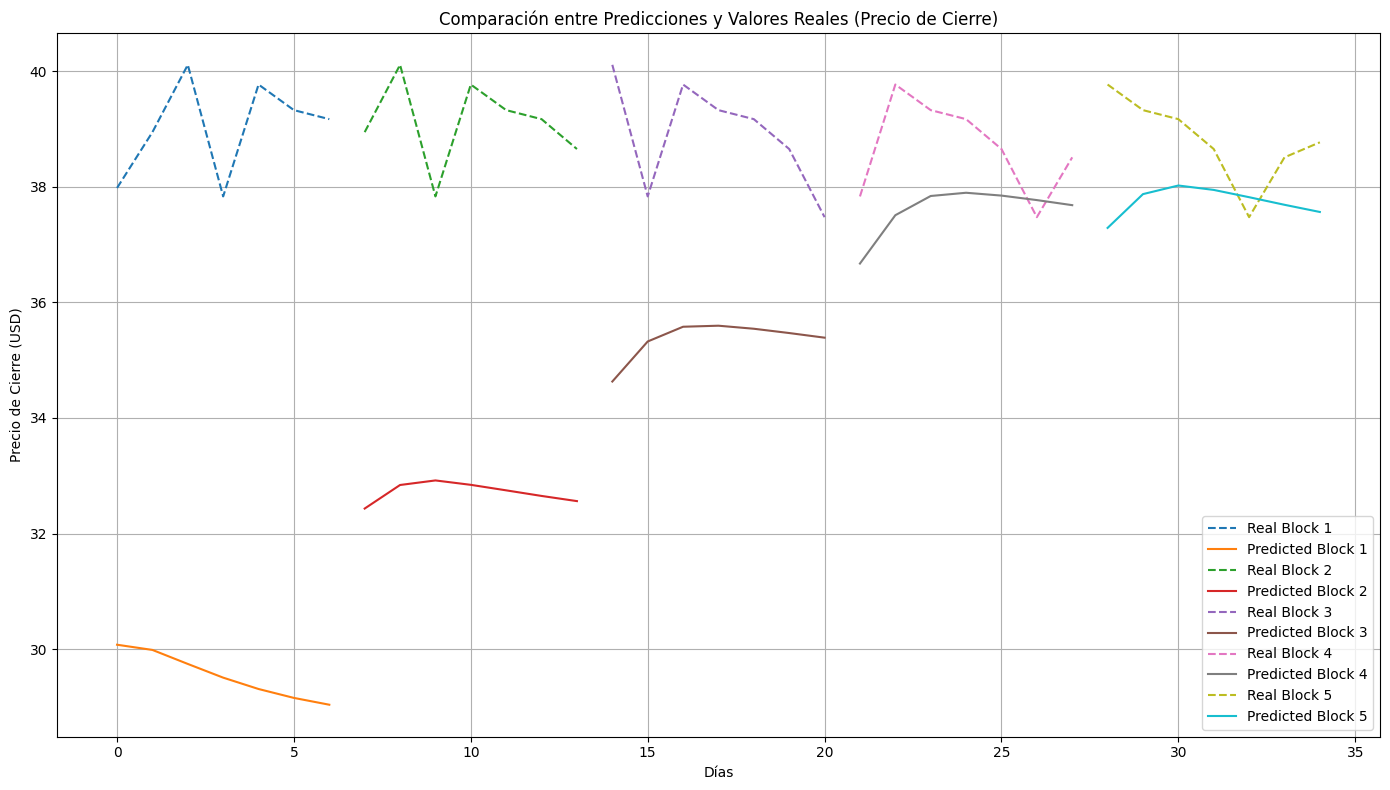

In [ ]:
import matplotlib.pyplot as plt

y_test_descaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_descaled = scaler.inverse_transform(y_pred.reshape(-1, 1))


num_blocks = 5
plt.figure(figsize=(14, 8))

for i in range(num_blocks):
    start = i * forecast_length
    end = start + forecast_length

    plt.plot(range(start, end), y_test_descaled[start:end], label=f'Real Block {i+1}', linestyle='dashed')
    plt.plot(range(start, end), y_pred_descaled[start:end], label=f'Predicted Block {i+1}')

plt.title('Comparación Predicciones y Valores Reales (Precio de Cierre)')
plt.xlabel('Días')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
